In [2]:
import os
from pathlib import Path
import scipy
import matplotlib.pyplot as plt
import numpy as np
import mne
from matplotlib import ticker
from tqdm.auto import tqdm
import textwrap
from typing import Union, List
from tqdm.auto import tqdm, trange
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

d:\new project\PD_&_EEG_Analysis\Parkinson_disease-EEG_Data_Analysis\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
notebook_journal = [ ] # This holds the notes for the models
mne.set_log_level("ERROR")
plt.ioff()


In [4]:
def gather_all_setFile_paths():
    return list(Path("ds004584-download").glob("**/*.set"))

def find_set_of_common_channels(filePaths):
    for idx,filepath in tqdm(enumerate(filePaths),total=len(filePaths), desc="Finding the set of common channels"):
        raw = mne.io.read_raw_eeglab(filepath)
        ch_names = raw.ch_names
        if idx == 0 :
            ch_names_holder = ch_names
        else: 
            ch_names_holder = list(set(ch_names_holder) & set(ch_names))
    return ch_names_holder

In [5]:
def get_sub_info(subject_id:str) -> pd.DataFrame:
    assert isinstance(subject_id,str),f"The subject_id has to be a string, got{type(subject_id)}"
    path_sub_info = Path(
        # "/kaggle/input", 
        # "rest-eyes-open-parkinsons-disease-64-channel-eeg", 
        "ds004584-download", 
        "participants.tsv")
    df_sub_info = pd.read_csv(path_sub_info,sep='/t')
    df_sub_info = df_sub_info[df_sub_info.participant_id ==str(subid)]
    return df_sub_info

def get_sub_data(sub_id:str) ->pd.DataFrame:
    assert isinstance(subject_id, str), f"The subject_id has to be a string, got {type(subject_id)}"
    
    # Find the EEGLab set file
    path_sub_dir = Path(
        # "/kaggle/input", 
        # "rest-eyes-open-parkinsons-disease-64-channel-eeg", 
        "ds004584-download",
        str(subject_id)
    )
    path_sub_set_file = list(path_sub_dir.glob("**/*"))
    if len(path_sub_set_file) > 1:
        raise Exception("More than one set file is found")
    else:
        path_sub_set_file = path_sub_set_file[0]
        raw = mne.io.read_raweeglab(path_sub_set_file)
        df_raw_eeg = pd.DataFrame(raw.get_data())
        df_raw_eeg["channel_name"] = raw.ch_names
        df_raw_eeg = df_raw_eeg.set_index("channel_name")
        return df_raw_eeg

In [6]:
def calculate_band_power(
    filepath:Path,
    channels:Union,
    brain_wave_bands:dict=None) -> pd.DataFrame:

    if brain_wave_bands is None:
        brain_wave_bands=dict(
            low_theta=(2,5),
            high_theta=(6,9),
            alpha=(10,15),
            beta=(16,25),
            low_gamma=(36,55),
            high_gamma_1=(65,89),
            high_gamma_2=(90,115)
            )
    raw = mne.io.read_raw_eeglab(filepath)
    spectrum = raw.compute_psd(picks=channels,n_jobs=-1)
    data,freqs = spectrum.get_data(return_freqs=True)
    holder_stats=np.ndarray((data.shape[0],len(brain_wave_bands)))

    for idx, (key,val) in enumerate(brain_wave_bands.items()):
        low_bound,high_bound = val[0],val[1]
        
        indices = np.argwhere(
            np.logical_and(
                freqs >= low_bound,
                freqs <= high_bound,
                
            )
        )
        holder_stats[:, idx] = np.sum(data[:, indices],axis=1).ravel()
    assert holder_stats.shape == (data.shape[0], len(brain_wave_bounds)),"Something is wrong."
    df_stats = pd.DataFrame(holder_stats)
    df_stats.columns = brain_wave_bounds.keys()
    df_stats["channel_name"] = channels
    df_stats = df_stats.set_index("channel_name")
    return df_stats

def create_df_band_power(filePaths:List[Path], channels:List[str]=None) -> pd.DataFrame:
    if channels is None:
        common_channels = find_set_of_common_channels(filePaths)
    
    holder_df = []
    
    for filepath in tqdm(filePath,total=len(filePaths),desc="Creating a dataframe of band powers"):
        df_band_power = calculate_band_power(filePaths,common_channels)
        participant_id = filepath.stem[:7]
        df_band_power["participant_id"] = [participant_id] * df_band_power.shape[0]
        df_band_power = df_band_power.reset_index()
        df_band_power = df_band_power.set_index(["participant_id","channel_name"])
        holder_df.append(df_band_power)
    
    df_band_powers= pd.concat(holder_df)
    
    return df_band_powers
    

In [21]:
def create_df_sub_info() -> pd.DataFrame:
    path_sub_info = Path(
        # "/kaggle/input", 
        # "rest-eyes-open-parkinsons-disease-64-channel-eeg", 
        "ds004584-download", 
        "participants.tsv")
    df_sub_info = pd.read_csv(path_sub_info,sep="/t")
    return df_sub_info

def create_df_psd(filePaths:List[Path],channels:List[str]=None) -> pd.DataFrame:
    if channels is None:
        common_channels = find_set_of_common_channels(filePaths)
    holder_df=[]
    
    for filepath in tqdm(filePaths, total=len(filePaths), desc="Creating DataFrame of PSD"):
        raw = mne.io.read_raw_eeglab(filepath)
        spectrum = raw.compute_psd(picks=common_channels,n_jobs=-1)
        data,freqs = spectrum.get_data(return_freqs=True)
        participant_id = filepath.stem[:7]
        df_psd= pd.DataFrame(data)
        df_psd["channel_name"] = common_channels
        df_psd["participant_id"] = participant_id
        df_psd = df_psd.set_index(["participant_id","channel_name"])
        holder_df.append(df_psd)
        
    df_psd = pd.concat(holder_df)
    return df_psd



# EDA

In [8]:
# Getting all the paths to the EEGLab '.set' files
filePaths = gather_all_setFile_paths()

In [9]:
# EDA
ith_path = 5

## Extract and read the EEGLab set/fdt file
filePath = filePaths[ith_path]
rawEegLab = mne.io.read_raw_eeglab(filePath)

print(f"Number of channels: {len(rawEegLab.ch_names)}")
print(f"Number of time points: {rawEegLab.n_times}")

Number of channels: 63
Number of time points: 131030


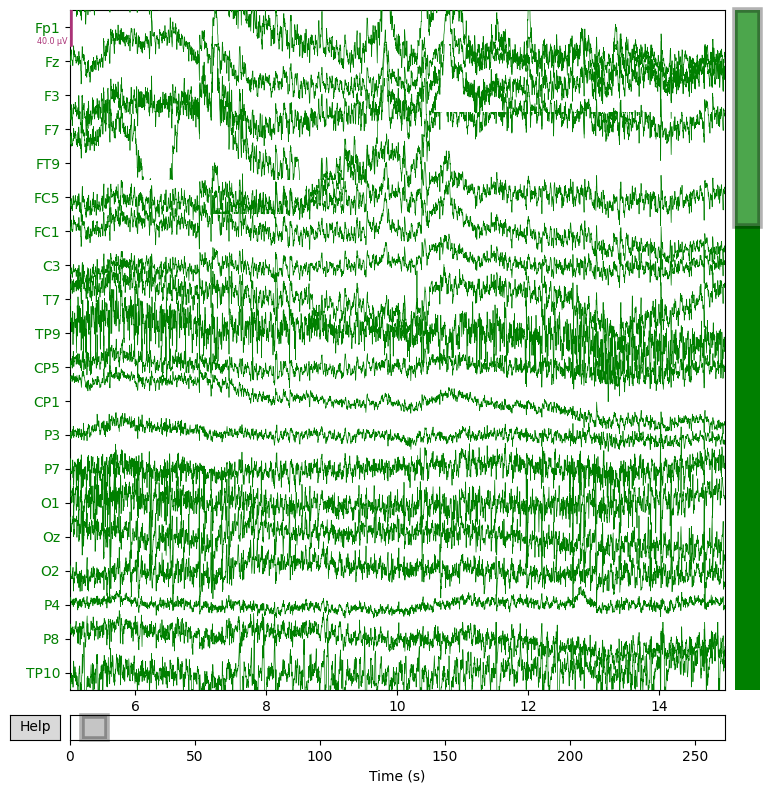

In [10]:
rawEegLab.plot(
    n_channels=20,
    color="green",
    start=5,
    duration=10
)
plt.show(
    
)

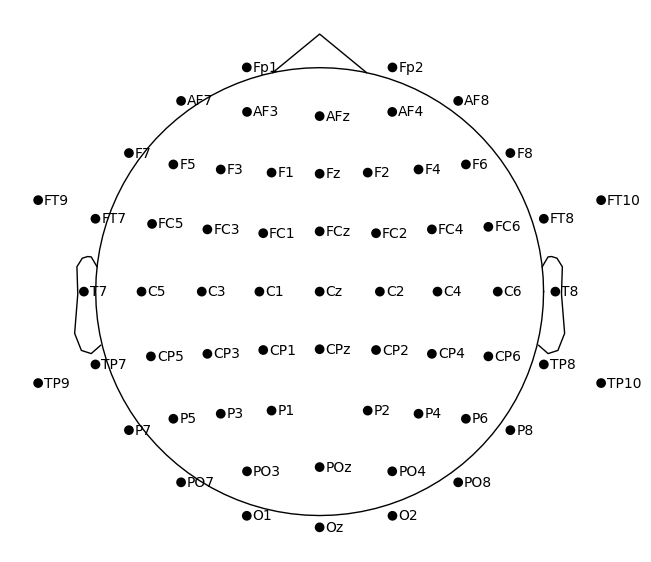

In [11]:
rawEegLab.plot_sensors(show_names=True)
plt.show()

d:\new project\PD_&_EEG_Analysis\Parkinson_disease-EEG_Data_Analysis\env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


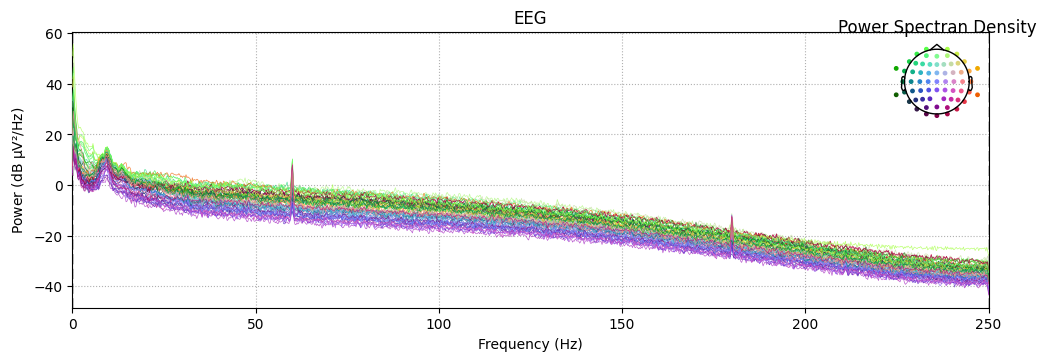

In [12]:
# Power spectral density
rawEegLab.compute_psd().plot(dB=True)
plt.title("Power Spectran Density")
plt.show()

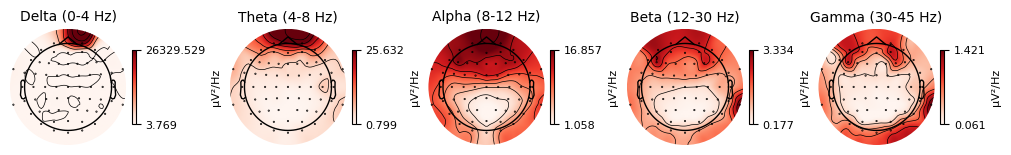

In [13]:
# PSD Tropology map
rawEegLab.compute_psd().plot_topomap()
plt.show()

C:\Users\mdmnb\AppData\Local\Temp\ipykernel_21084\3498534638.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


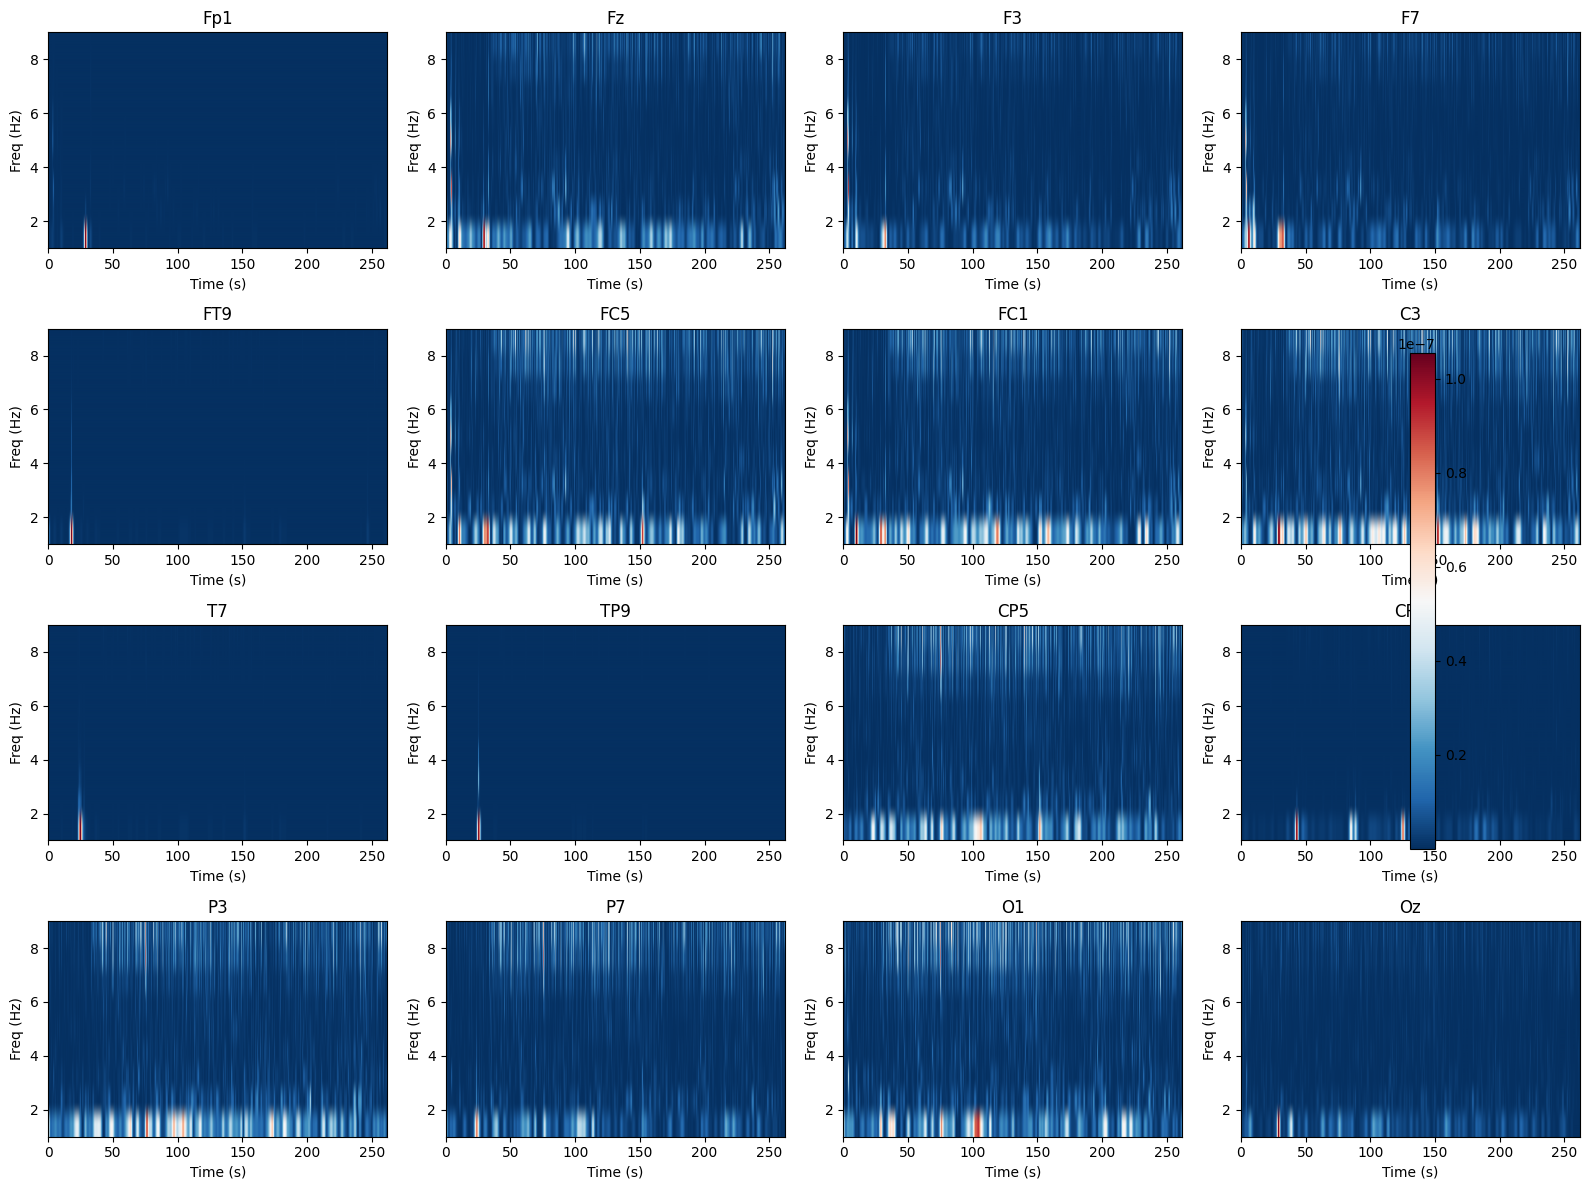

In [19]:
# ...existing code...

subset_channels = rawEegLab.ch_names[:16]
rawTfr = rawEegLab.compute_tfr("morlet", list(range(1, 10)), n_jobs=-1, picks=subset_channels)

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, ch_name in enumerate(subset_channels):
    ax = axes[idx]
    # Get the TFR data for this channel
    ch_idx = rawTfr.ch_names.index(ch_name)
    tfr_data = rawTfr.data[ch_idx]
    # Plot the TFR as an image
    im = ax.imshow(
        tfr_data,
        aspect='auto',
        origin='lower',
        extent=[rawTfr.times[0], rawTfr.times[-1], rawTfr.freqs[0], rawTfr.freqs[-1]],
        cmap='RdBu_r'
    )
    ax.set_title(ch_name)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Freq (Hz)')

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
warnings.filterwarnings("ignore")

subject_info = create_df_sub_info()
subject_info.drop("TYPE",axis=1,inplace=True)
sns.pairplot(subject_info,hue="GROUP",palette={"PD":'Red',"Control":"Blue"})

plt.show()

ValueError: No variables found for grid columns.

In [32]:
subject_info = create_df_sub_info()
# Only drop "TYPE" if it exists and keep numeric columns
if "TYPE" in subject_info.columns:
    subject_info = subject_info.drop("TYPE", axis=1)
print(subject_info.head())
print(subject_info.dtypes)
# Now plot
sns.pairplot(subject_info, hue="GROUP", palette={"PD": 'Red', "Control": "Blue"})
plt.show()

  participant_id\tGROUP\tID\tEEG\tAGE\tGENDER\tMOCA\tUPDRS\tTYPE
0        sub-001\tPD\t1001\tPD1001\t80\tM\t19\t28\t1            
1        sub-002\tPD\t1011\tPD1011\t81\tM\t17\t25\t1            
2        sub-003\tPD\t1021\tPD1021\t68\tF\t26\t10\t1            
3        sub-004\tPD\t1031\tPD1031\t80\tM\t22\t10\t1            
4        sub-005\tPD\t1041\tPD1041\t56\tM\t21\t13\t1            
participant_id\tGROUP\tID\tEEG\tAGE\tGENDER\tMOCA\tUPDRS\tTYPE    object
dtype: object


ValueError: No variables found for grid columns.